We need 'Impact Function' from CLIMADA to get the damage curve. There are two ways to have damage curves: (1) empirical curve; (2) prior curve with special attentions given to V_thre and V_mid.

In [ ]:
from climada.entity import ImpfTropCyclone, ImpactFunc, ImpactFuncSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [47]:
intensity = pd.read_excel('intensity_array.xlsx')

In [48]:
damage_curve_intensity = np.array(intensity.iloc[:,0])

In [50]:
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa(impf_id=1, intensity=damage_curve_intensity, v_thresh=25.7, v_half=70.8, scale=1.0)

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

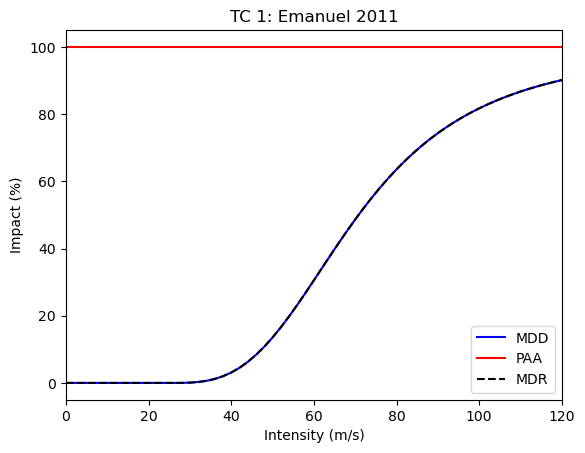

In [51]:
impFunc_emanuel_usa.plot()

We want to generate an array. For each intensity, we will have the corresponding TDR.

In [56]:
imp_fun_set = ImpactFuncSet([impFunc_emanuel_usa])

In [57]:
# provide absolute path of the input excel file
file_name = 'intensity_filled.xlsx'
# fill ImpactFuncSet from Excel file
imp_set_xlsx = imp_fun_set.write_excel(file_name)

Accordingly, we need to change the logic of the damage curve smoothing function from PRISK source code.

Below is the original code.

In [ ]:
def convert_to_continous_damage(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max((damage_curves["depth"] + 0.01)*100)))})
    continuous_curves["index"] = continuous_curves["index"]/100
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="depth")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("depth", inplace=True)
    return continuous_curves

Let's modify it.

In [58]:
def convert_to_continous_damage(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max(damage_curves["intensity"]))+1)})
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="intensity")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("intensity", inplace=True)
    return continuous_curves

Let's now test the modified function runs correctly.

In [112]:
damage_curves_tc = pd.read_excel('intensity_filled.xlsx')

In [113]:
damage_curves_tc_smoothed = convert_to_continous_damage(damage_curves_tc)

<Axes: xlabel='intensity'>

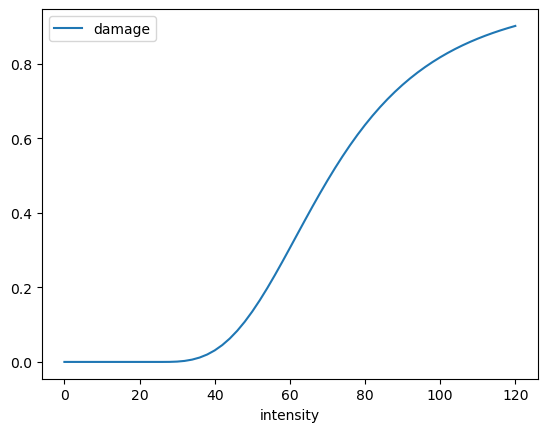

In [115]:
damage_curves_tc_smoothed[['damage']].plot()

Protection and damage from the damage curves data will be used.

In [104]:
def convert_to_continous_production(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max(damage_curves["damage"])*100+1))})
    continuous_curves["index"] = continuous_curves["index"]/100
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="damage")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("damage", inplace=True)
    return continuous_curves

In [105]:
damage_production = pd.read_excel('damage_curves.xlsx')

In [106]:
damage_production = pd.DataFrame(damage_production[['damage','production']])

In [107]:
production = convert_to_continous_production(damage_production)

In [ ]:
damage = damage_curves_tc['damage']

interp_production = np.interp(damage, damage_production['damage'], damage_production['production'])

interp_df = pd.DataFrame({
    'damage': damage,
    'production': interp_production
})

In [119]:
interp_df.to_excel('interpolated_production.xlsx')